<a href="https://colab.research.google.com/github/jgermanob/DeepLearning/blob/master/T01/AP_T01_Ej03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Regresión lineal con pytorch
Entrena y evalúa un modelo de regresión lineal para el conjunto de datos de calificaciones que
considere los dos atributos de entrada.

## Especificaciones
* Grafica los datos en 3D.
* Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio nivel.
* Prueba distintos valores para los hiperparámetros.

In [1]:
import plotly.express as px
import plotly.graph_objects as go

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random
#from torchinfo import summary
from matplotlib import cm

In [3]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

### Lectura de datos

In [4]:
url = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2022-1/data/califs.csv'

In [5]:
df = pd.read_csv(url)

In [6]:
df.head()

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


In [7]:
X = df[['prev', 'horas']].to_numpy(dtype='float32')
y = df['calif'].to_numpy(dtype='float32').reshape(-1,1)

In [8]:
X = torch.tensor(X)
y = torch.tensor(y)

In [9]:
ds = TensorDataset(X, y)

### Cargador de datos

In [10]:
def build_dl(dataset, batch_size=16):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Gráfica de datos en 3D

In [11]:
x = df['prev'].to_numpy()
y = df['horas'].to_numpy()
z = df['calif'].to_numpy()

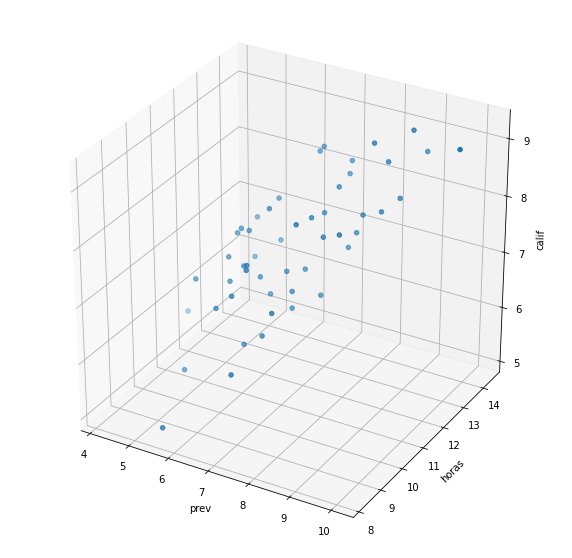

In [12]:
fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('prev')
ax.set_ylabel('horas')
ax.set_zlabel('calif')
ax.scatter(x,y,z)
plt.show()

In [13]:
fig = px.scatter_3d(df, x='prev', y='horas', z='calif')
fig.show()

In [14]:
def plot_solution(df, model, ax):
    g = 100
    X = df[['prev', 'horas']].to_numpy(dtype='float32')
    x_1 = np.linspace((X[:,0].min()-1), (X[:,0].max()+1), g, dtype=np.float32)
    x_2 = np.linspace((X[:,1].min()-1), (X[:,1].max()+1), g, dtype=np.float32)
    
    X1, X2 = np.meshgrid(x_1, x_2)
    X_mesh = np.zeros((g**2,2), dtype=np.float32)
    X_mesh[:,0] = X1.flatten()
    X_mesh[:,1] = X2.flatten()
    Y = model(torch.tensor(X_mesh)).detach().numpy()
    fig = plt.figure(figsize=(10.0,10.0))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X1, X2, Y.reshape((g,g)), cmap=cm.jet, antialiased=True, shade=True, alpha=0.5, linewidth=0.)
    
    x = df['prev'].to_numpy()
    y = df['horas'].to_numpy()
    z = df['calif'].to_numpy()
    
    print(y.shape, Y.shape)
    
    ax.set_xlabel('prev')
    ax.set_ylabel('horas')
    ax.set_zlabel('calif')
    ax.scatter(x,y,z, marker='^')
    
    plt.show()

In [31]:
def plot_sol(df, model):
    g = 100
    X = df[['prev', 'horas']].to_numpy(dtype='float32')
    x_1 = np.linspace((X[:,0].min()-1), (X[:,0].max()+1), g, dtype=np.float32)
    x_2 = np.linspace((X[:,1].min()-1), (X[:,1].max()+1), g, dtype=np.float32)
    
    X1, X2 = np.meshgrid(x_1, x_2)
    X_mesh = np.zeros((g**2,2), dtype=np.float32)
    X_mesh[:,0] = X1.flatten()
    X_mesh[:,1] = X2.flatten()
    Y = model(torch.tensor(X_mesh)).detach().numpy()
    y_pred = model(torch.tensor(X)).detach().numpy().reshape(50,)
    fig = go.Figure(data=[go.Surface(z=Y.reshape((g,g)), x=X1, y=X2)])

    x = df['prev'].to_numpy()
    y = df['horas'].to_numpy()
    z = df['calif'].to_numpy()

    print(y_pred.shape, y.shape)
    fig.add_scatter3d(x=x, y=y, z=z, mode='markers')
    fig.add_scatter3d(x=x, y=y, z=y_pred, mode='markers', marker=dict(colorscale='blues'))
    fig.show()

### Definición de arquitectura con API de medio nivel nivel

In [16]:
class Linear_regression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Linear_regression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

### Definición de arquitectura con API de alto nivel

In [17]:
def build_model(input_dim, output_dim):
    return torch.nn.Sequential(torch.nn.Linear(input_dim, output_dim))

### Función para realizar entrenamiento

In [18]:
def train_model(model, dl, learning_rate, epochs):
    opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        loss_hst = []
        for x, y_true in dl: 
            output = model(x)
            loss = F.mse_loss(output, y_true)
            opt.zero_grad()
            loss.backward()
            opt.step()
            loss_hst.append(loss.item()*100)
        
        loss = np.mean(loss_hst)
        print('Epoch: {}\tLoss = {}'.format(epoch, loss))

In [19]:
input_dim = 2
output_dim = 1
learning_rate = 1e-5
epochs = 200

### Entrenamiento de modelo construido mediante API de medio nivel

In [20]:
set_seed()
dl = build_dl(ds)
model_ml = Linear_regression(input_dim, output_dim)

In [21]:
#summary(model_ml)

In [ ]:
train_model(model_ml, dl,learning_rate, epochs)

In [32]:
plot_sol(df, model_ml)

(50,) (50,)


### Entrenamiento de modelo construido mediante API de alto nivel

In [26]:
set_seed()
dl = build_dl(ds)
model_hl = build_model(input_dim, output_dim)

In [27]:
#summary(model_hl)

In [28]:
train_model(model_hl, dl,learning_rate, epochs)

Epoch: 0	Loss = 1193.2473421096802
Epoch: 1	Loss = 1048.2634544372559
Epoch: 2	Loss = 1056.1041355133057
Epoch: 3	Loss = 1051.9536018371582
Epoch: 4	Loss = 1022.7558612823486
Epoch: 5	Loss = 987.5914573669434
Epoch: 6	Loss = 933.8356018066406
Epoch: 7	Loss = 963.1911039352417
Epoch: 8	Loss = 910.1413249969482
Epoch: 9	Loss = 917.5870895385742
Epoch: 10	Loss = 823.6495018005371
Epoch: 11	Loss = 780.5131196975708
Epoch: 12	Loss = 765.8118844032288
Epoch: 13	Loss = 758.1819534301758
Epoch: 14	Loss = 755.8865904808044
Epoch: 15	Loss = 730.5245399475098
Epoch: 16	Loss = 683.5058927536011
Epoch: 17	Loss = 687.7362489700317
Epoch: 18	Loss = 726.1634349822998
Epoch: 19	Loss = 747.249448299408
Epoch: 20	Loss = 635.4572534561157
Epoch: 21	Loss = 606.9218873977661
Epoch: 22	Loss = 569.8631882667542
Epoch: 23	Loss = 593.7808871269226
Epoch: 24	Loss = 576.2713074684143
Epoch: 25	Loss = 547.035801410675
Epoch: 26	Loss = 499.2799997329712
Epoch: 27	Loss = 482.77515172958374
Epoch: 28	Loss = 459.70708